In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

%matplotlib inline

In [2]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sys.path.append("/home/Developer/NCSN-TF2.0/")

import PIL
import pickle
import utils, configs
import argparse
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
# import tensorflow_probability as tfp
import matplotlib.pyplot as plt

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from helper import plot_confusion_matrix, metrics

from datasets.dataset_loader import  *
from tqdm import tqdm
from sklearn.metrics import classification_report, average_precision_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from PIL import Image
from IPython.display import display
from matplotlib.pyplot import imshow
from datetime import datetime

import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid

sns.set(style="darkgrid")
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

tf.__version__

'2.3.1'

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.experimental.list_physical_devices('GPU')

Num GPUs Available:  0


[]

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [5]:
def pixel_reshape(X):
    X = X.reshape(*X.shape[0:2], -1)
    X = np.swapaxes(X, 0,2)
    return X

In [6]:
from ood_detection_helper import *

model = load_model(inlier_name="fashion_mnist", checkpoint=-1, filters=64,
                   save_path="/home/Developer/NCSN-TF2.0/longleaf_models/",
                   split="100,0"
                  )
model.trainable = False

(1, 28, 28, 1)
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 64)   640         images[0][0]                     
__________________________________________________________________________________________________
idx_sigmas (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
conditional_full_pre_activation (None, 28, 28, 64)   77696       conv2d[0][0]                     
                                                                 idx_sig

In [7]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 64)   640         images[0][0]                     
__________________________________________________________________________________________________
idx_sigmas (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
conditional_full_pre_activation (None, 28, 28, 64)   77696       conv2d[1][0]                     
                                                                 idx_sigmas[0][0]      

In [8]:
TEST_BATCH = 3

@tf.function
def preproc(x):
    x = tf.image.rgb_to_grayscale(x)
    x = tf.image.resize(x, size=[28,28])
    x/=255
    return x


def load_dataset(name):
    data_generators = tfds.load(name=name, batch_size=-1,
                                data_dir="../data",
                                shuffle_files=True,
                                split = ["test"]
                               )
    testset = tf.data.Dataset.from_tensor_slices(data_generators[0]['image'])
    testset = testset.map(lambda x: x/255, num_parallel_calls=AUTOTUNE)
    testset = testset.batch(TEST_BATCH).take(1)
    
    return testset

with tf.device('CPU'):
    # load dataset from tfds (or use downloaded version if exists)
    mnist_test = load_dataset("mnist")
    cifar_test = load_dataset("cifar10").map(preproc, num_parallel_calls=AUTOTUNE)
    
    fashion_train, fashion_test = get_train_test_data("fashion_mnist")
    fashion_train = fashion_train.batch(TEST_BATCH)
    fashion_test = fashion_test.batch(TEST_BATCH).take(1)

Split: ['train', 'test']


In [9]:
# SIGMAS = utils.get_sigma_levels()
# sigma = tf.Variable(tf.ones([x.shape[0]], dtype=tf.dtypes.int32))

In [10]:
# inlier = next(iter(fashion_train))
# ood = next(iter(mnist_test))
# inlier.shape, ood.shape

In [11]:
def plot_gradients(x):
    x=tf.Variable(x)
    ds_dx = []

    for idx,sigma_val in enumerate(SIGMAS):
        sigma = idx*tf.ones([x.shape[0]], dtype=tf.dtypes.int32)
        with tf.GradientTape() as tape:
            score = model([x, sigma]) * sigma_val
        grad = tape.gradient(score, x)
        ds_dx.append(grad.numpy())
        # ds_dsi = tape.gradient(score, sigma)

    fig = plt.figure(figsize=(12, 12.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                     axes_pad=0.5,  # pad between axes in inch.
    #                  share_all=True,
                     cbar_location="right",
                     cbar_mode="each",
                     cbar_size="5%",
                     cbar_pad="2%",
                     )
    ds_dx = np.array(ds_dx)
    for i, (ax, cax, ds) in enumerate(zip(grid, grid.cbar_axes, ds_dx)):
        # Iterating over the grid returns the Axes.
        im = ds[0,...,-1] ** 2
        im = ax.imshow(im)
        fig.colorbar(im, cax=cax)
        ax.grid(False)

    plt.show()
    
    return ds_dx

### Getting Score Distributions

In [12]:
# score_dict = {"train": train_pixel_scores,
#               "test":  fashion_pixel_scores,
#               "mnist": mnist_pixel_scores,
#               "cifar": cifar_pixel_scores
#              }

# with open("fashion_pixel_scores.p", "wb") as f:
#     pickle.dump(score_dict, f)

with open("fashion_pixel_scores.p", "rb") as f:
    score_dict = pickle.load(f)

In [13]:
train_pixel_scores = score_dict["train"]
fashion_pixel_scores = score_dict["test"]
mnist_pixel_scores = score_dict["mnist"]
cifar_pixel_scores = score_dict["cifar"]
train_pixel_scores.shape

(784, 60000, 10)

In [16]:
from scipy.stats import percentileofscore as ps

make_image = lambda x:  np.swapaxes(x, 0,1).reshape(x.shape[1], 28,28)

In [177]:
X_train_images = X_train.reshape(28,28, X_train.shape[1], X_train.shape[2])

In [188]:
'''
Outputs a tensor of size (d*d) x n_samples x 3*3*n_dims
'''
def kernel(x, img_sz=28):
    
    # Define output matrix
    outshape= (img_sz*img_sz, x.shape[1], 3*3*x.shape[2])
    out = np.zeros(outshape)
    
    # Reshape and pad with zeros
    px = x.reshape(img_sz,img_sz, x.shape[1], x.shape[2])
    px = np.pad(px, ((1,1), (1,1), (0,0), (0,0)))
#     print(px.shape)
    
    idx = 0
    for i in range(1, px.shape[0]-1):
        for j in range(1, px.shape[1]-1):
            feat_vec = px[i-1:i+2,i-1:i+2, ...]
#             print(feat_vec.shape)
            
            # Features of neighbours in a 3x3 grid
            feat_vec = feat_vec.reshape(-1, x.shape[1],x.shape[2])
#             print(feat_vec.shape)
            feat_vec = np.concatenate(feat_vec,axis=1)
#             print(feat_vec.shape)
            out[idx, ...] = feat_vec
            idx += 1
    return out

In [191]:
%%time
X_train_nbrs = kernel(train_pixel_scores)
fashion_nbrs = kernel(fashion_pixel_scores)
mnist_nbrs = kernel(mnist_pixel_scores)
cifar_nbrs = kernel(cifar_pixel_scores)

CPU times: user 7.59 s, sys: 2.44 s, total: 10 s
Wall time: 10 s


In [196]:
X_train_nbrs.shape

(784, 60000, 90)

In [206]:
from sklearn.neighbors import NearestNeighbors
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
CPUS = 6
N_NEIGHBOURS = 3

def trainer(X):

    chunksize = 4
    # progress_bar = tqdm(range(len(models)))
    models = []

    def train_fn(i):
        return NearestNeighbors(n_neighbors=N_NEIGHBOURS,
                             algorithm='kd_tree').fit(X[i])

    with ThreadPoolExecutor(max_workers = CPUS) as exc:
        result = list(exc.map(train_fn, list(range(len(X)))))
    
    return np.array(result)

In [207]:
def get_pixel_scores(x):

    chunksize = 4
    # progress_bar = tqdm(range(len(models)))

    def score_fn(i):
        return models[i].kneighbors(x[i])[0][:, -1]


    with ThreadPoolExecutor(max_workers = CPUS) as exc:
    #     for idx in progress_bar:
    #         result = list(exc.map(preprocessor,
    #                               paths[idx_ : idx_+chunksize]))
    #         progress_bar.set_description("# Processed: {:d}".format(idx_))

        result = list(exc.map(score_fn, list(range(len(models)))))
    
    return np.array(result)

In [208]:
%%time
models = trainer(X_train_nbrs)

CPU times: user 1h 37min, sys: 2min 59s, total: 1h 40min
Wall time: 1h 36min 28s


In [199]:
%%time

models = []
for i in range(X_train.shape[0]):
    models.append(
        NearestNeighbors(n_neighbors=N_NEIGHBOURS,
                         algorithm='kd_tree').fit(X_train_nbrs[i])
    )

CPU times: user 1h 38min 39s, sys: 10.7 s, total: 1h 38min 49s
Wall time: 1h 38min 52s


In [193]:
from scipy.stats import percentileofscore as ps

make_image = lambda x:  np.swapaxes(x, 0,1).reshape(x.shape[1], 28,28)

In [59]:
# def get_pixel_scores(x):
#     kd_scores = []

#     for i in range(x.shape[0]):
#         kd_scores.append(
#             models[i].kneighbors(x[i])[0][:, -1]
#         )

#     kd_scores = np.array(kd_scores)
#     return kd_scores

In [25]:
%%time
train_scores = {}
train_scores["pixel_kd"] = get_pixel_scores(train_pixel_scores)

NameError: name 'make_image' is not defined

In [29]:
train_scores["images_kd"] = make_image(train_scores["pixel_kd"])

In [201]:
%%time
fashion_scores = {}
fashion_scores["pixel_kd"] = get_pixel_scores(fashion_nbrs)
fashion_scores["images_kd"] = make_image(fashion_scores["pixel_kd"])

CPU times: user 1h 5min 57s, sys: 12.2 s, total: 1h 6min 10s
Wall time: 16min 34s


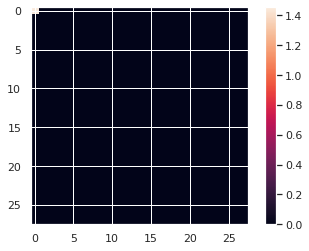

In [202]:
plt.imshow(fashion_scores["images_kd"][42])
plt.colorbar()

In [ ]:
fashion_scores

In [209]:
%%time
mnist_scores = {}
mnist_scores["pixel_kd"] = get_pixel_scores(mnist_nbrs)
mnist_scores["images_kd"] = make_image(mnist_scores["pixel_kd"])

CPU times: user 1h 7min 46s, sys: 7.06 s, total: 1h 7min 53s
Wall time: 11min 21s


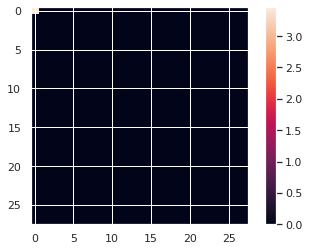

In [210]:
plt.imshow(mnist_scores["images_kd"][0])
plt.colorbar()

In [ ]:
mnist_pixel_scores.shape, cifar_pixel_scores.shape

In [35]:
%%time
cifar_scores = {}
cifar_scores["pixel_kd"] = get_pixel_scores(cifar_nbrs)
cifar_scores["images_kd"] = make_image(cifar_scores["pixel_kd"])

CPU times: user 14.7 s, sys: 1.59 s, total: 16.3 s
Wall time: 4.16 s


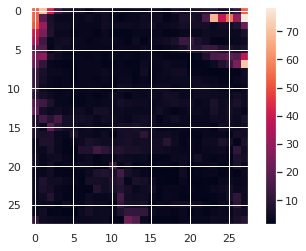

In [36]:
plt.imshow(cifar_scores["images_kd"][0])
plt.colorbar()

In [39]:
fashion_scores["pixel_kd"].shape

(784, 512)

In [66]:
%%time
from scipy.stats import percentileofscore as ps

baseline = fashion_scores["pixel_kd"]

def percentile_score(x):
    pixel_ps = [ps(baseline[i], s) for i,s in (enumerate(x))]
    pixel_ps = np.array(pixel_ps).reshape(28,28)
    return pixel_ps

CPU times: user 39 µs, sys: 0 ns, total: 39 µs
Wall time: 55.8 µs


In [73]:
thresh = 80
with ThreadPoolExecutor(max_workers = CPUS) as exc:
    ps_results = np.array(list(exc.map(percentile_score, mnist_scores["pixel_kd"].T[:4])))
    mnist_scores["images_kd_ps"] = ps_results
    mnist_scores["images_kd_ps"][ps_results < thresh] = 0

with ThreadPoolExecutor(max_workers = CPUS) as exc:
    ps_results = np.array(list(exc.map(percentile_score, fashion_scores["pixel_kd"].T[:4])))
    fashion_scores["images_kd_ps"] = ps_results
    fashion_scores["images_kd_ps"][ps_results < thresh] = 0

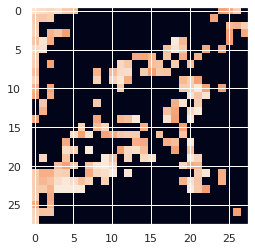

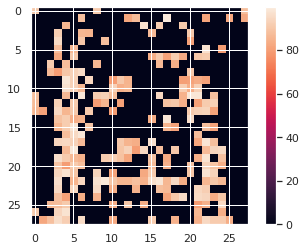

In [74]:
plt.imshow(mnist_scores["images_kd_ps"][0])
plt.show()
plt.imshow(fashion_scores["images_kd_ps"][0])
plt.colorbar()

In [83]:
fashion_samples = next(iter(fashion_test)).numpy()[...,-1]
mnist_samples = next(iter(mnist_test)).numpy()[...,-1]

In [235]:
%timeit [x for sublist in list(zip([0,1,2],[3,4,5])) for x in sublist]

1.9 µs ± 341 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


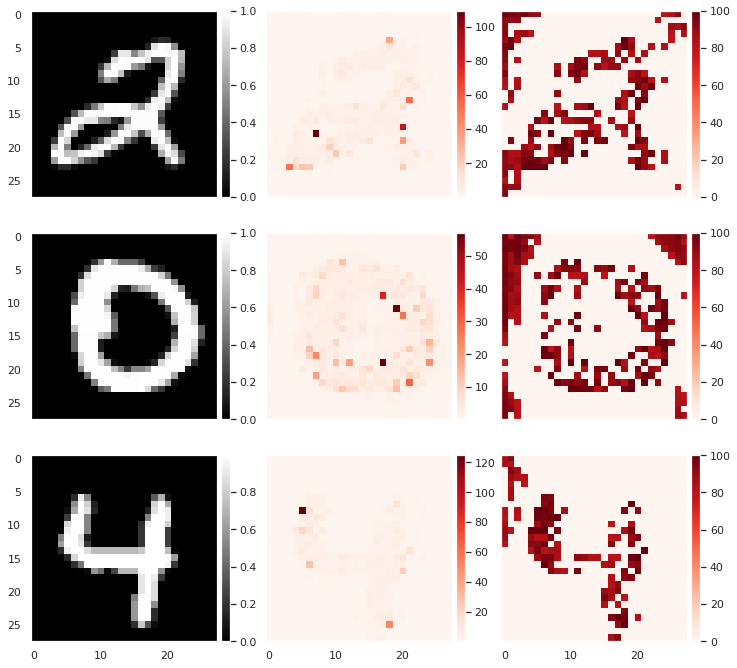

In [77]:
from mpl_toolkits.axes_grid1 import ImageGrid
N=3
images = list(zip(mnist_samples[:N],
                  mnist_scores["images_kd"][:N],
                  mnist_scores["images_kd_ps"][:N]
                 ))
py_flat = lambda l: [x for sublist in l for x in sublist]
images = py_flat(images)

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12, 12.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
#                  share_all=True,
                 cbar_location="right",
                 cbar_mode="each",
                 cbar_size="5%",
                 cbar_pad="2%",
                 )

for i, (ax, cax, im) in enumerate(zip(grid, grid.cbar_axes, images)):
    # Iterating over the grid returns the Axes.
    if i%3 == 0:
        _cmap="gray"
    else:
        _cmap="Reds"
        
    im = ax.imshow(im, cmap=_cmap)
    fig.colorbar(im, cax=cax)
    ax.grid(False)

plt.show()

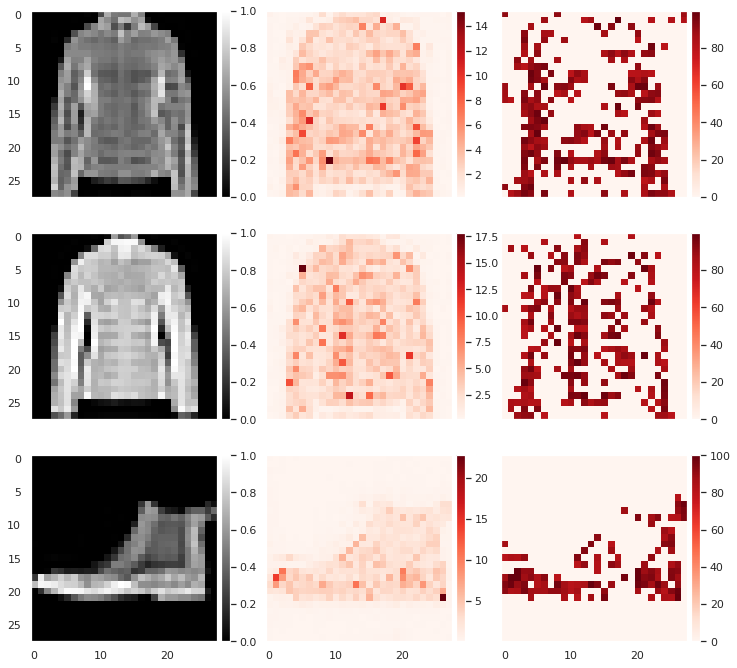

In [84]:
N=3
images = list(zip(fashion_samples[:N],
                  fashion_scores["images_kd"][:N],
                  fashion_scores["images_kd_ps"][:N]
                 ))
py_flat = lambda l: [x for sublist in l for x in sublist]
images = py_flat(images)

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(12, 12.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.5,  # pad between axes in inch.
#                  share_all=True,
                 cbar_location="right",
                 cbar_mode="each",
                 cbar_size="5%",
                 cbar_pad="2%",
                 )

for i, (ax, cax, im) in enumerate(zip(grid, grid.cbar_axes, images)):
    # Iterating over the grid returns the Axes.
    if i%3 == 0:
        _cmap="gray"
    else:
        _cmap="Reds"
        
    im = ax.imshow(im, cmap=_cmap)
    fig.colorbar(im, cax=cax)
    ax.grid(False)

plt.show()